In [1]:
%matplotlib inline
# Load all necessary packages
import sys
import pandas  as pd
import numpy   as np
import seaborn as sns
sns.set()
sns.set_context("talk")
import matplotlib.pyplot as plt
# Import IBM's AI Fairness tooolbox
from aif360.datasets         import BinaryLabelDataset
from aif360.metrics          import BinaryLabelDatasetMetric
from aif360.metrics          import ClassificationMetric
from aif360.metrics.utils    import compute_boolean_conditioning_vector
from aif360.algorithms.preprocessing.lfr import LFR
# Import scikit-learn core slibraries
from sklearn.metrics         import auc, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split  
from sklearn.ensemble        import RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.metrics         import balanced_accuracy_score
from sklearn.preprocessing   import StandardScaler, MinMaxScaler
from sklearn.metrics         import accuracy_score
from IPython.display         import Markdown, display
from typing                  import List, Union, Dict
# Warnings will be used to silence various model warnings for tidier output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the cleaned Taiwan-Credit-Card-Cleaned-Marriage dataset
Taiwan_df = pd.read_csv('./input/Taiwan-Credit-Card-Cleaned-Gender.csv')

In [3]:
# Set privileged (1)/ unprivileged (0)/ favourable (1) / unfavourable values (0)
protected_attr      = 'GENDER'
priv_grp            = 1  # Males 
unpriv_grp          = 0  # Females  
lab                 = 'DEFAULT'
fav_label           = 1 # Will not default next month
unfav_label         = 0 # Will default next month
privileged_groups   = [{protected_attr: priv_grp}]   # Males
unprivileged_groups = [{protected_attr: unpriv_grp}] # Females

In [4]:
# Create a Binary Label Dataset to use with AIF360 APIs
X = Taiwan_df.drop(lab,axis=1)
y = Taiwan_df[lab]

In [5]:
Taiwan_bld = BinaryLabelDataset(df=pd.concat((X, y), axis=1),
                                label_names=[lab], protected_attribute_names=[protected_attr],
                                favorable_label=fav_label, unfavorable_label=unfav_label)

In [6]:
# Create train and test datasets
Taiwan_train_bld, Taiwan_test_bld = Taiwan_bld.split([0.7], shuffle=True, seed=101)

In [7]:
scaler = MinMaxScaler(copy=False)
Taiwan_train_bld.features = scaler.fit_transform(Taiwan_train_bld.features)
Taiwan_test_bld.features  = scaler.fit_transform(Taiwan_test_bld.features)

In [8]:
Taiwan_train_df, d = Taiwan_train_bld.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=False)
Taiwan_test_df,  d = Taiwan_test_bld.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=False)

In [9]:
# First test whether it is possible to predict the Sensitive Variable from the whole original dataset
X_se_train = Taiwan_train_df.drop(protected_attr,axis=1)
y_se_train = Taiwan_train_df[protected_attr]
X_se_test  = Taiwan_test_df.drop(protected_attr,axis=1)
y_se_test  = Taiwan_test_df[protected_attr]

Se_BiasedLogModel = LogisticRegression(random_state=101)
Se_BiasedRfcModel = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)
Se_BiasedLogModel.fit(X_se_train, y_se_train) 
Se_BiasedRfcModel.fit(X_se_train, y_se_train) 
yseLog_pred =  Se_BiasedLogModel.predict(X_se_test)
yseRfc_pred =  Se_BiasedRfcModel.predict(X_se_test)
# Now test whether we can predict Gender from the test dataset
print('Model Accuracy for predicting the Sensitive Variable before bias transformation:')
print(f"Biased Logistic regression validation accuracy: {Se_BiasedLogModel.score(X_se_test, y_se_test)}")
print(f"Biased Random Forest       validation accuracy: {Se_BiasedRfcModel.score(X_se_test, y_se_test)}")
print('')
print('Biased Balanced accuracy')
print(f"Biased Logistic regression balanced accuracy  : {balanced_accuracy_score(y_se_test, yseLog_pred)}")
print(f"Biased Random Forest       balanced accuracy  : {balanced_accuracy_score(y_se_test, yseRfc_pred)}")

Model Accuracy for predicting the Sensitive Variable before bias transformation:
Biased Logistic regression validation accuracy: 0.6068888888888889
Biased Random Forest       validation accuracy: 0.6177777777777778

Biased Balanced accuracy
Biased Logistic regression balanced accuracy  : 0.5373862551374088
Biased Random Forest       balanced accuracy  : 0.520567235989953


In [10]:
# Next get the number of labels from the modified training dataset
print('Training Before - DEFAULT value counts:')
print(Taiwan_train_df.DEFAULT.value_counts())
print('Training Before - GENDER value counts:')
print(Taiwan_train_df.GENDER.value_counts())

Training Before - DEFAULT value counts:
1.0    16389
0.0     4611
Name: DEFAULT, dtype: int64
Training Before - GENDER value counts:
0.0    12661
1.0     8339
Name: GENDER, dtype: int64


In [11]:
# Determine the baseline model accuracy for Logistic Regression and Random Forest Classifiers
X_train = Taiwan_train_df.drop(lab,axis=1)
y_train = Taiwan_train_df[lab]
X_test  = Taiwan_test_df.drop(lab,axis=1)
y_test  = Taiwan_test_df[lab]
BiasedLogModel = LogisticRegression(random_state=101)
BiasedRfcModel = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)
BiasedLogModel.fit(X_train, y_train) 
BiasedRfcModel.fit(X_train, y_train)
BiasedLogPredictions = BiasedLogModel.predict(X_test)
BiasedRfcPredictions = BiasedRfcModel.predict(X_test)
print(f"Biased Logistic regression validation accuracy: {BiasedLogModel.score(X_test, y_test)}")
print(f"Biased Random Forest       validation accuracy: {BiasedRfcModel.score(X_test, y_test)}")
print('')
print(f"Biased Logistic regression balanced accuracy  : {balanced_accuracy_score(y_test, BiasedLogPredictions)}")
print(f"Biased Random forest balanced accuracy        : {balanced_accuracy_score(y_test, BiasedRfcPredictions)}")

Biased Logistic regression validation accuracy: 0.8091111111111111
Biased Random Forest       validation accuracy: 0.8013333333333333

Biased Logistic regression balanced accuracy  : 0.6432656312226205
Biased Random forest balanced accuracy        : 0.5963679808841099


In [12]:
#Test for equality of odds. 
Test_Log_bld = Taiwan_test_bld.copy(deepcopy=True)
Test_Rfc_bld = Taiwan_test_bld.copy(deepcopy=True)
TestLogPredictions = BiasedLogModel.predict(X_test)
TestRfcPredictions = BiasedRfcModel.predict(X_test)
Test_Log_bld.labels= TestLogPredictions
Test_Rfc_bld.labels= TestRfcPredictions

c_Log_metric = ClassificationMetric(Taiwan_test_bld, Test_Log_bld, 
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)
c_Rfc_metric = ClassificationMetric(Taiwan_test_bld, Test_Rfc_bld, 
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)

In [13]:
print('A value of 0 means that equality of odds has been met')
print('Log average_abs_odds_difference:', c_Log_metric.average_abs_odds_difference())
print('Log average_odds_difference:    ', c_Log_metric.average_odds_difference())
print(' ')
print('Rfc average_abs_odds_difference:', c_Rfc_metric.average_abs_odds_difference())
print('Rfc average_odds_difference:    ', c_Rfc_metric.average_odds_difference())

A value of 0 means that equality of odds has been met
Log average_abs_odds_difference: 0.03038466728143191
Log average_odds_difference:     0.03038466728143191
 
Rfc average_abs_odds_difference: 0.007236598916128545
Rfc average_odds_difference:     0.004143497146549768


In [14]:
# Create the binary label dataset metric class for the training dataset
metric_train_bld = BinaryLabelDatasetMetric(Taiwan_train_bld, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
display(Markdown("#### Biased training dataset"))
print('Number of instances           :', metric_train_bld.num_instances())
print("Base Rate                     :%f" % metric_train_bld.base_rate())
print('Consistency                   :', metric_train_bld.consistency())
print('Disparate Impact              :', metric_train_bld.disparate_impact())
print('Mean Difference               :', metric_train_bld.mean_difference())
print('Statistical Parity Difference :', metric_train_bld.statistical_parity_difference()) 
print('# of positives(privileged)    :', metric_train_bld.num_positives(privileged=True))
print('# of positives(non-privileged):', metric_train_bld.num_positives(privileged=False))
print('Total positive instances"     :', metric_train_bld.num_positives(privileged=True)+metric_train_bld.num_positives(privileged=False))
print('# of negatives(privileged)    :', metric_train_bld.num_negatives(privileged=True))
print('# of negatives(non-privileged):', metric_train_bld.num_negatives(privileged=False))
print('Total negative instances"     :', metric_train_bld.num_negatives(privileged=True)+metric_train_bld.num_negatives(privileged=False))

#### Biased training dataset

Number of instances           : 21000.0
Base Rate                     :0.780429
Consistency                   : [0.78541905]
Disparate Impact              : 1.039129494340016
Mean Difference               : 0.029833951914356782
Statistical Parity Difference : 0.029833951914356782
# of positives(privileged)    : 6358.0
# of positives(non-privileged): 10031.0
Total positive instances"     : 16389.0
# of negatives(privileged)    : 1981.0
# of negatives(non-privileged): 2630.0
Total negative instances"     : 4611.0


In [15]:
# Fit the Learning Fair Representations on the biased training data
print('Interval : Optimization objective value for the interval')
TR = LFR(unprivileged_groups = unprivileged_groups, privileged_groups = privileged_groups,verbose=1, seed=101)
TR = TR.fit(Taiwan_train_bld)

Interval : Optimization objective value for the interval
250 12751.693259585165
500 11907.542622423689
750 11450.170771883902
1000 11409.46328821306
1250 11340.324193353648
1500 11151.792202402656
1750 14426.531785042116
2000 10926.796893972538
2250 10823.318363423907
2500 10942.988244625412
2750 10775.68765225979
3000 10681.164593007095
3250 10511.44607477657
3500 13445.029658632422
3750 10393.372306211664
4000 10328.715489191409
4250 10258.026128843281
4500 10233.434684056445
4750 10118.577926215108
5000 10071.293380536932


In [16]:
# Transform training data and align features
Taiwan_train_lfr = TR.transform(Taiwan_train_bld)

In [17]:
display(Markdown("#### Transformed training dataset"))
from sklearn.metrics import classification_report
thresholds = np.linspace(0.1, 0.9, 9)
for threshold in thresholds:
    # Transform training data and align features
    Taiwan_train_lfr = TR.transform(Taiwan_train_bld,threshold=threshold)
    metric_train_lfr = BinaryLabelDatasetMetric(Taiwan_train_lfr, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("Classification threshold = %f" % threshold)
    print('Consistency                   :', metric_train_lfr.consistency())
    print('Disparate Impact              :', metric_train_lfr.disparate_impact())
    print('Mean Difference               :', metric_train_lfr.mean_difference())
    print('')

#### Transformed training dataset

Classification threshold = 0.100000
Consistency                   : [0.99991429]
Disparate Impact              : 1.0006181853335858
Mean Difference               : 0.0006169250924693559

Classification threshold = 0.200000
Consistency                   : [0.99994286]
Disparate Impact              : 1.0020869294137602
Mean Difference               : 0.002076168175627169

Classification threshold = 0.300000
Consistency                   : [0.99977143]
Disparate Impact              : 1.0067767561525067
Mean Difference               : 0.006697115655691088

Classification threshold = 0.400000
Consistency                   : [0.99955238]
Disparate Impact              : 1.0137729217984475
Mean Difference               : 0.013440944669116939

Classification threshold = 0.500000
Consistency                   : [0.9990381]
Disparate Impact              : 1.0286012736057295
Mean Difference               : 0.026677144274536935

Classification threshold = 0.600000
Consistency                   : [0

In [18]:
threshold = 0.35 # Chosen because the disparate impact is closest to 1.
Taiwan_train_lfr = TR.transform(Taiwan_train_bld,threshold=threshold)

In [19]:
metric_train_lfr = BinaryLabelDatasetMetric(Taiwan_train_lfr, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)

In [20]:
print('THIS IS WHAT THE AIF CODE PRODUCES FROM THE LAST CLASSIFICATION THRESHOLD RUN ABOVE')
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_train_lfr.mean_difference())
print('Number of instances           :', metric_train_lfr.num_instances())
print("Base Rate                     :%f" % metric_train_lfr.base_rate())
print('Consistency                   :', metric_train_lfr.consistency())
print('Disparate Impact              :', metric_train_lfr.disparate_impact())
print('Mean Difference               :', metric_train_lfr.mean_difference())
print('Statistical Parity Difference :', metric_train_lfr.statistical_parity_difference()) 
print('# of positives(privileged)    :', metric_train_lfr.num_positives(privileged=True))
print('# of positives(non-privileged):', metric_train_lfr.num_positives(privileged=False))
print('Total positive instances"     :', metric_train_lfr.num_positives(privileged=True)+metric_train_lfr.num_positives(privileged=False))
print('# of negatives(privileged)    :', metric_train_lfr.num_negatives(privileged=True))
print('# of negatives(non-privileged):', metric_train_lfr.num_negatives(privileged=False))
print('Total negative instances"     :', metric_train_lfr.num_negatives(privileged=True)+metric_train_lfr.num_negatives(privileged=False))
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_train_bld.mean_difference())

THIS IS WHAT THE AIF CODE PRODUCES FROM THE LAST CLASSIFICATION THRESHOLD RUN ABOVE
Difference in mean outcomes between unprivileged and privileged groups = 0.009236
Number of instances           : 21000.0
Base Rate                     :0.989619
Consistency                   : [0.99966667]
Disparate Impact              : 1.0093853126399295
Mean Difference               : 0.009235624837901524
Statistical Parity Difference : 0.009235624837901524
# of positives(privileged)    : 8206.0
# of positives(non-privileged): 12576.0
Total positive instances"     : 20782.0
# of negatives(privileged)    : 133.0
# of negatives(non-privileged): 85.0
Total negative instances"     : 218.0


#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.029834


In [21]:
# Convert the transformed Binary Labelled Datasets to a pandas dataframe for consistency 
Taiwan_train_lfr_df, d = Taiwan_train_lfr.convert_to_dataframe(de_dummy_code=False, sep='=', set_category=False)

In [22]:
# Determine the transformed model accuracy for Logistic Regression and Random Forest Classifiers
X_lfr_train = Taiwan_train_lfr_df.drop(lab,axis=1)
y_lfr_train = Taiwan_train_lfr_df[lab]
X_lfr_test  = Taiwan_test_df.drop(lab,axis=1)
y_lfr_test  = Taiwan_test_df[lab]

UnbiasedLogModel = LogisticRegression(random_state=101)
UnbiasedRfcModel = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)
UnbiasedLogModel.fit(X_lfr_train, y_lfr_train) 
UnbiasedRfcModel.fit(X_lfr_train, y_lfr_train) 
UnbiasedLogPredictions = UnbiasedLogModel.predict(X_lfr_test)
UnbiasedRfcPredictions = UnbiasedRfcModel.predict(X_lfr_test)

print(f"Unbiased Logistic regression validation accuracy: {UnbiasedLogModel.score(X_lfr_test, y_lfr_test)}")
print(f"Unbiased Random Forest       validation accuracy: {UnbiasedRfcModel.score(X_lfr_test, y_lfr_test)}")
print('')
print(f"UnBiased Logistic regression balanced accuracy  : {balanced_accuracy_score(y_lfr_test, UnbiasedLogPredictions)}")
print(f"Unbiased Random Forest       balanced accuracy  : {balanced_accuracy_score(y_lfr_test, UnbiasedRfcPredictions)}")

Unbiased Logistic regression validation accuracy: 0.7765555555555556
Unbiased Random Forest       validation accuracy: 0.7758888888888889

UnBiased Logistic regression balanced accuracy  : 0.5055595380326563
Unbiased Random Forest       balanced accuracy  : 0.5044285145360414


In [23]:
#Test for equality of odds. 
Test_Log_bld = Taiwan_test_bld.copy(deepcopy=True)
Test_Rfc_bld = Taiwan_test_bld.copy(deepcopy=True)
TestLogPredictions = UnbiasedLogModel.predict(X_test)
TestRfcPredictions = UnbiasedRfcModel.predict(X_test)
Test_Log_bld.labels= TestLogPredictions
Test_Rfc_bld.labels= TestRfcPredictions

c_Log_metric = ClassificationMetric(Taiwan_test_bld, Test_Log_bld, 
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)
c_Rfc_metric = ClassificationMetric(Taiwan_test_bld, Test_Rfc_bld, 
                                unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups)

In [24]:
print('A value of 0 means that equality of odds has been met')
print('Log average_abs_odds_difference:', c_Log_metric.average_abs_odds_difference())
print('Log average_odds_difference:    ', c_Log_metric.average_odds_difference())
print(' ')
print('Rfc average_abs_odds_difference:', c_Rfc_metric.average_abs_odds_difference())
print('Rfc average_odds_difference:    ', c_Rfc_metric.average_odds_difference())

A value of 0 means that equality of odds has been met
Log average_abs_odds_difference: 0.005991718449694594
Log average_odds_difference:     0.005991718449694594
 
Rfc average_abs_odds_difference: 0.0035179772848553115
Rfc average_odds_difference:     0.0035179772848553115


Accuracy:


,LogReg,RFC
Biased,0.809111,0.801333
Fair,0.776556,0.775889


AUC:


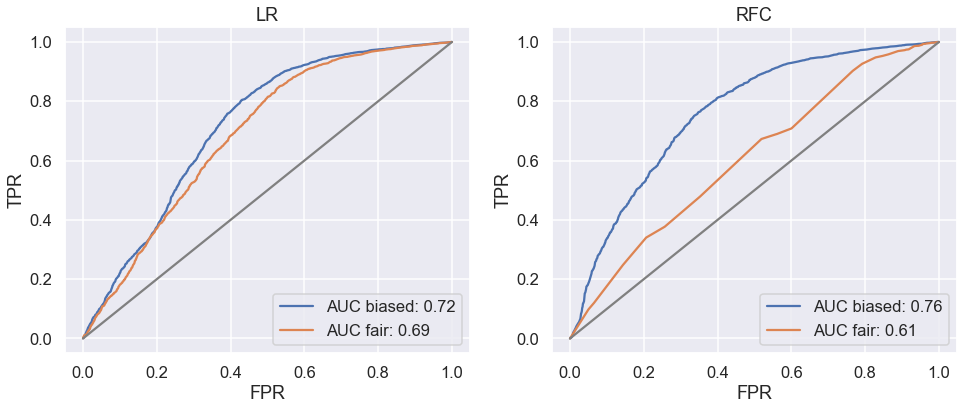

In [25]:
%matplotlib inline
def plot_auc(y_true: np.ndarray, preds: Dict[str, np.ndarray], title: str='', ax=None) -> None:
    leg = []
    for k, p in preds.items():
        fpr, tpr, _ = roc_curve(y_true, p)
        ax = sns.lineplot(x=fpr, y=tpr, ci=None, ax=ax)
        leg.append(f"{k}: {round(auc(fpr, tpr), 2)}")
   
    ax.legend(leg)
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    sns.lineplot(x=[0, 1], y=[0, 1], color='gray',ax=ax)
    ax.set_title(title)
    
print('Accuracy:')
display(pd.DataFrame({'LogReg': [BiasedLogModel.score(X_test, y_test), 
                                 UnbiasedLogModel.score(X_lfr_test, y_lfr_test)],
                      'RFC': [BiasedRfcModel.score(X_test, y_test),
                              UnbiasedRfcModel.score(X_lfr_test, y_lfr_test)]}, 
                      index =['Biased', 'Fair']))

print('AUC:')

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16, 6))
plot_auc(y_test, 
         {'AUC biased': BiasedLogModel.predict_proba(X_test)[:, 1],
          'AUC fair': UnbiasedLogModel.predict_proba(X_lfr_test)[:, 1]},
         title='LR', ax=ax[0]) 
plot_auc(y_test, 
         {'AUC biased': BiasedRfcModel.predict_proba(X_test)[:, 1],
          'AUC fair': UnbiasedRfcModel.predict_proba(X_lfr_test)[:, 1]},
         title='RFC', ax=ax[1]) 
plt.show()

In [26]:
def feature_importance(mod: Union[LogisticRegression, RandomForestClassifier], names: List[str],scale=None) -> pd.DataFrame:
    """Return feature importance for LR or RFC models in a sorted DataFrame."""
    if type(mod) == LogisticRegression:
        imp = np.abs(mod.coef_.squeeze()) / scale
        var = np.zeros(shape=imp.shape)
    elif type(mod) == RandomForestClassifier:
        imps = np.array([fi.feature_importances_ for fi in mod.estimators_])
        imp = imps.mean(axis=0)
        var = imps.std(axis=0)

    return pd.DataFrame({'feature': names, 'importance': imp,
                         'std': var}).sort_values('importance', ascending=False)

def plot_feature_importance(**kwargs) -> None:
    ax = sns.barplot(**kwargs)
    for l in ax.get_xticklabels():
        l.set_rotation(90)

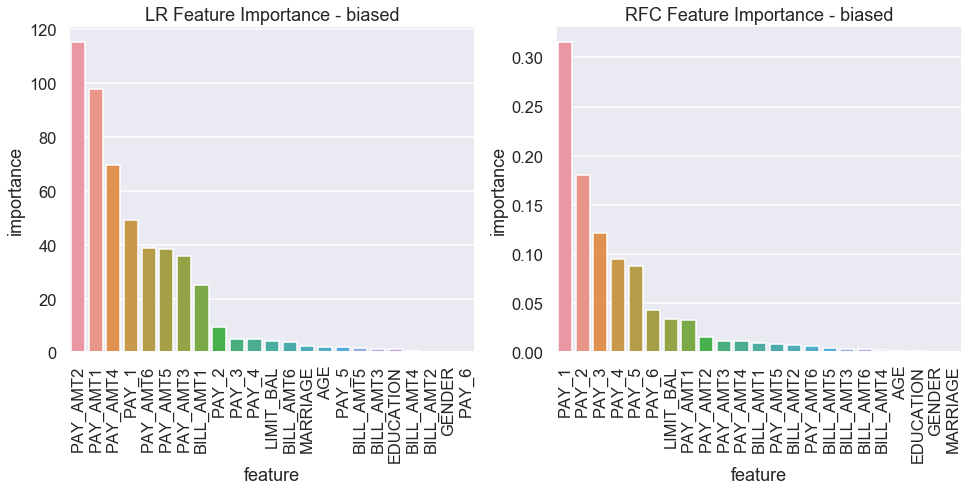

In [27]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

plot_feature_importance(x='feature', y='importance', 
                        data=feature_importance(BiasedLogModel, names=X_train.columns.tolist(),
                                                scale=X_train.std()), ax=ax[0])
_ = ax[0].set_title('LR Feature Importance - biased')
plot_feature_importance(x='feature', y='importance', 
                        data=feature_importance(BiasedRfcModel, names=X_train.columns.tolist()), ax=ax[1])
_ = ax[1].set_title('RFC Feature Importance - biased')

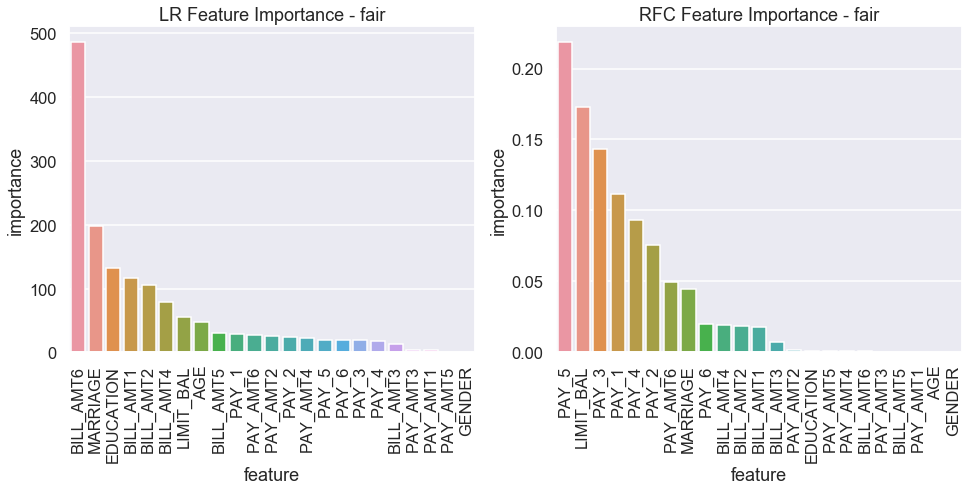

In [28]:
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

plot_feature_importance(x='feature', y='importance', 
                        data=feature_importance(UnbiasedLogModel, names=X_lfr_train.columns.tolist(), 
                                                scale=X_lfr_train.std()), ax=ax[0])
_ = ax[0].set_title('LR Feature Importance - fair')
plot_feature_importance(x='feature', y='importance', 
                        data=feature_importance(UnbiasedRfcModel, names=X_lfr_train.columns.tolist()), ax=ax[1])
_ = ax[1].set_title('RFC Feature Importance - fair')

In [29]:
def calc_metrics(mod, x: pd.DataFrame, y_true: pd.DataFrame) -> pd.DataFrame:
    """Calculate fairness metrics at each model threshold."""
    
    # Create a BinaryLabelDataset (as before training)
    bld = BinaryLabelDataset(df=pd.concat((x, y_true), axis=1),label_names=[lab],
                                  protected_attribute_names=[protected_attr],
                                  favorable_label=fav_label, unfavorable_label=unfav_label)

    # Create a second set to hold the predicted labels
    bld_preds = bld.copy(deepcopy=True)
    preds = mod.predict_proba(x)[:, 1] # for all the rows, retain the 2nd value.
                                       # preds will contain a single column table of all 
                                       # probabilities that the classification will be 1.
    accuracy          = []
    balanced_accuracy = []
    disp_impact       = []
    average_abs_odds_difference = []
    avg_odd_diff = []
    equal_opportunity_difference = []
    error_rate = []
    
    # For threshold values between 0 and 1:
    thresh = np.linspace(0.01, 0.99, 100) # generate 100 evenly spaced values from 0.01->0.99 
    for t in thresh:
        
        # Apply threshold and set labels in bld for predictions
        bld_preds.labels[preds > t] = 1  # labels is a structured dataset attribute.
        bld_preds.labels[preds <= t] = 0

        # Calculate the metrics for this threshold
        valid_metric = ClassificationMetric(bld, bld_preds, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)

        # Save the balanced accuracy of the model, and the metrics
        accuracy.append(valid_metric.accuracy())
        balanced_accuracy.append(0.5 * (valid_metric.true_positive_rate()
                                        + valid_metric.true_negative_rate()))
#        disp_impact.append(np.abs(valid_metric.disparate_impact() - 0.5))
        disp_impact.append(np.abs(valid_metric.disparate_impact()))
        average_abs_odds_difference.append(valid_metric.average_abs_odds_difference())
        avg_odd_diff.append(valid_metric.average_odds_difference())
        equal_opportunity_difference.append(valid_metric.equal_opportunity_difference())
        error_rate.append(valid_metric.error_rate())

    # Return as df indexed by threshold
    metrics = pd.DataFrame({'accuracy': accuracy,
                            'balanced_accuracy': balanced_accuracy,
                            'disparate_impact': disp_impact,
                            'average_abs_odds_difference': average_abs_odds_difference,
                            'avg_odds_diff': avg_odd_diff,
                            'equal_opportunity_diff': equal_opportunity_difference},
                            index=thresh)
#'error_rate': error_rate},
    return metrics


def plot_metrics(metrics: pd.DataFrame, 
                 title: str='', **kwargs) -> None:
    """Plot the metrics df from calc_metrics with seaborn."""
    ax = sns.lineplot(data=metrics, 
                      **kwargs)
    ax.set_title(title)
    ax.set_xlabel('Classification threshold')

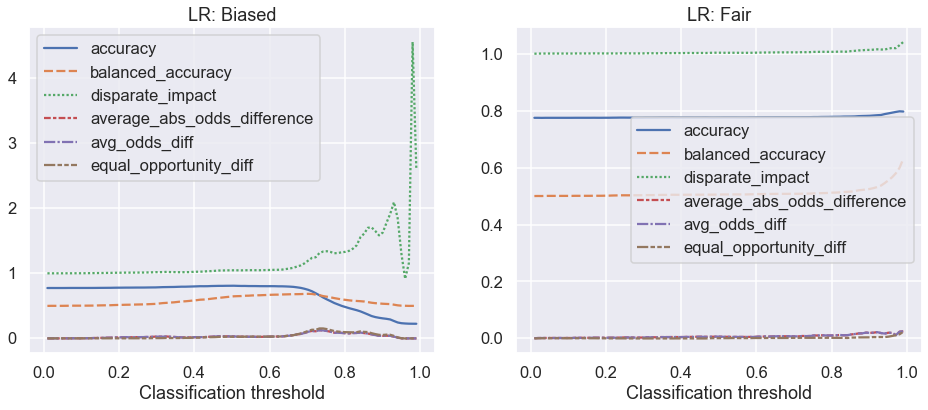

In [30]:
# Plot for Logistic Regression Classifier
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
with warnings.catch_warnings():
     warnings.simplefilter('ignore', RuntimeWarning)
    
     plot_metrics(calc_metrics(BiasedLogModel, X_test, y_test), ax=ax[0], title="LR: Biased")
 
     plot_metrics(calc_metrics(UnbiasedLogModel, X_lfr_test, y_lfr_test), ax=ax[1], title="LR: Fair")

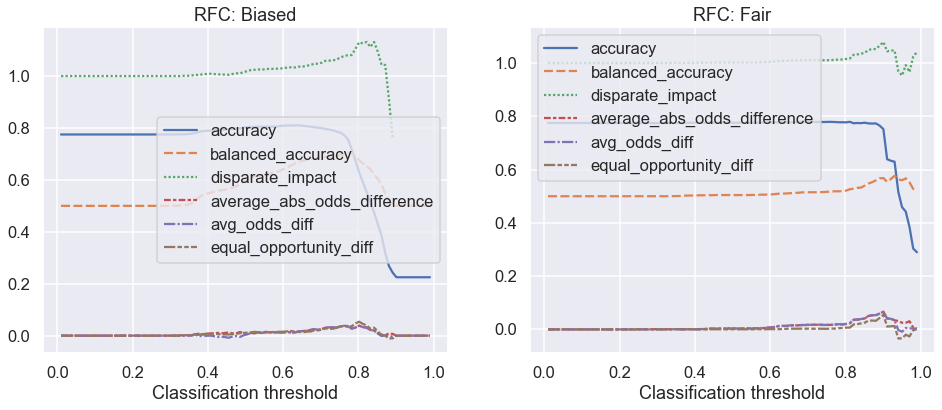

In [31]:
# Plot for Random Forest Classifier
%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
with warnings.catch_warnings():
    warnings.simplefilter('ignore', RuntimeWarning)
    
    plot_metrics(calc_metrics(BiasedRfcModel, X_test, y_test), ax=ax[0], title="RFC: Biased")
    
    plot_metrics(calc_metrics(UnbiasedRfcModel, X_lfr_test, y_lfr_test), ax=ax[1], title="RFC: Fair")

In [32]:
display(Markdown("#### Individual fairness metrics"))
print("Consistency of labels in transformed training dataset= %f" %metric_train_lfr.consistency())
print("Consistency of labels in original training dataset= %f" %metric_train_bld.consistency())

#### Individual fairness metrics

Consistency of labels in transformed training dataset= 0.999667
Consistency of labels in original training dataset= 0.785419


In [33]:
# Check whether the transform on the original dataset has worked. 
# A false means that the dataset is transformed.
Taiwan_train_lfr_df.equals(Taiwan_train_df)

False

In [34]:
Taiwan_train_df     = Taiwan_train_df.reset_index(drop=True)
Taiwan_train_lfr_df = Taiwan_train_lfr_df.reset_index(drop=True)
TaiwanBool          = (Taiwan_train_df != Taiwan_train_lfr_df).stack()  # Create Frame of comparison booleans
Taiwandiff          = pd.concat([Taiwan_train_df.stack()[TaiwanBool], Taiwan_train_lfr_df.stack()[TaiwanBool]], axis=1)
Taiwandiff.columns  =["Taiwan_train_df", "Taiwan_train_lfr"]
print(Taiwandiff)

                 Taiwan_train_df  Taiwan_train_lfr
0     LIMIT_BAL         0.063291          0.295649
      EDUCATION         0.333333          0.364272
      MARRIAGE          0.333333          0.480114
      AGE               0.482759          0.209385
      PAY_1             0.300000         -0.266078
      PAY_2             0.000000         -0.096247
      PAY_3             0.000000          0.035761
      PAY_4             0.000000          0.032534
      PAY_5             0.000000          0.104654
      PAY_6             0.000000          0.013309
      BILL_AMT1         0.181479          0.237651
      BILL_AMT2         0.083212          0.127518
      BILL_AMT3         0.184931          0.222258
      BILL_AMT4         0.193873          0.255084
      BILL_AMT5         0.089884          0.148046
      BILL_AMT6         0.373913          0.449270
      PAY_AMT1          0.000000         -0.123833
      PAY_AMT2          0.000000         -0.220932
      PAY_AMT3          0.00000

In [35]:
## PCA Analysis of consitency

In [36]:
# At this stage the transformed dataframe will have the last threshold encountered!
feat_cols = Taiwan_train_bld.feature_names

orig_df = pd.DataFrame(Taiwan_train_bld.features,columns=feat_cols)
orig_df['label'] = Taiwan_train_bld.labels
orig_df['label'] = orig_df['label'].apply(lambda i: str(i))

transf_df = pd.DataFrame(Taiwan_train_lfr.features,columns=feat_cols)
transf_df['label'] = Taiwan_train_lfr.labels
transf_df['label'] = transf_df['label'].apply(lambda i: str(i))

In [37]:
from sklearn.decomposition import PCA

orig_pca = PCA(n_components=3)
orig_pca_result = orig_pca.fit_transform(orig_df[feat_cols].values)

orig_df['pca-one'] = orig_pca_result[:,0]
orig_df['pca-two'] = orig_pca_result[:,1] 
orig_df['pca-three'] = orig_pca_result[:,2]

display(Markdown("#### Original training dataset"))
print('Explained variation per principal component:')
print(orig_pca.explained_variance_ratio_)

#### Original training dataset

Explained variation per principal component:
[0.46856823 0.15087781 0.11729929]


In [38]:
transf_pca = PCA(n_components=3)
transf_pca_result = transf_pca.fit_transform(transf_df[feat_cols].values)

transf_df['pca-one'] = transf_pca_result[:,0]
transf_df['pca-two'] = transf_pca_result[:,1] 
transf_df['pca-three'] = transf_pca_result[:,2]

display(Markdown("#### Transformed training dataset"))
print('Explained variation per principal component:')
print(transf_pca.explained_variance_ratio_)

#### Transformed training dataset

Explained variation per principal component:
[0.96896624 0.02925945 0.00176873]


In [39]:
###Load, clean up original test data and compute metric

In [40]:
display(Markdown("#### Testing Dataset shape"))
print(Taiwan_test_bld.features.shape)

metric_test_bld = BinaryLabelDatasetMetric(Taiwan_test_bld, 
                                            unprivileged_groups=unprivileged_groups,
                                            privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_test_bld.mean_difference())

#### Testing Dataset shape

(9000, 23)


#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.043487


In [41]:
###Transform test data and compute metric

In [42]:
Taiwan_test_lfr = TR.transform(Taiwan_test_bld, threshold=threshold)
metric_test_lfr = BinaryLabelDatasetMetric(Taiwan_test_lfr, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)

In [43]:
print("Consistency of labels in tranformed test dataset= %f" %metric_test_lfr.consistency())

Consistency of labels in tranformed test dataset= 0.999844


In [44]:
print("Consistency of labels in original test dataset= %f" %metric_test_bld.consistency())

Consistency of labels in original test dataset= 0.778667


In [45]:
def check_algorithm_success():
#   """Transformed dataset consistency should be greater than original dataset."""
    assert metric_test_lfr.consistency() > metric_test_bld.consistency(), "Transformed dataset consistency should be greater than original dataset."
print(check_algorithm_success())

None


In [46]:
# Is it possible to predict the Sensitive Variable from the transformed dataset
X_se_train = Taiwan_train_lfr_df.drop(protected_attr,axis=1)
y_se_train = Taiwan_train_lfr_df[protected_attr]
X_se_test  = Taiwan_test_df.drop(protected_attr,axis=1)
y_se_test  = Taiwan_test_df[protected_attr]

Se_UnbiasedLogModel = LogisticRegression(random_state=101)
Se_UnbiasedRfcModel = RandomForestClassifier(n_estimators=100,max_depth=4,random_state=101)
Se_UnbiasedLogModel.fit(X_se_train, y_se_train) 
Se_UnbiasedRfcModel.fit(X_se_train, y_se_train) 
yseLog_pred =  Se_UnbiasedLogModel.predict(X_se_test)
yseRfc_pred =  Se_UnbiasedRfcModel.predict(X_se_test)
# Now test whether we can predict Gender from the test dataset
print('Model Accuracy for predicting the Sensitive Variable before bias transformation:')
print(f"Biased Logistic regression validation accuracy: {Se_UnbiasedLogModel.score(X_se_test, y_se_test)}")
print(f"Biased Random Forest       validation accuracy: {Se_UnbiasedRfcModel.score(X_se_test, y_se_test)}")
print('')
print('Biased Balanced accuracy')
print(f"Biased Logistic regression balanced accuracy  : {balanced_accuracy_score(y_se_test, yseLog_pred)}")
print(f"Biased Random Forest       balanced accuracy  : {balanced_accuracy_score(y_se_test, yseRfc_pred)}")

Model Accuracy for predicting the Sensitive Variable before bias transformation:
Biased Logistic regression validation accuracy: 0.5178888888888888
Biased Random Forest       validation accuracy: 0.6003333333333334

Biased Balanced accuracy
Biased Logistic regression balanced accuracy  : 0.4857890158893503
Biased Random Forest       balanced accuracy  : 0.4983500123206317


In [47]:
# Lastly get the number of labels from the modified training dataset
print('Training After - DEFAULT value counts:')
print(Taiwan_train_lfr_df.DEFAULT.value_counts())
print('Training After - GENDER value counts:')
print(Taiwan_train_lfr_df.GENDER.value_counts())

Training After - DEFAULT value counts:
1.0    20782
0.0      218
Name: DEFAULT, dtype: int64
Training After - GENDER value counts:
0.0    12661
1.0     8339
Name: GENDER, dtype: int64
